# Simulating Wireless Network Using NS2 and Python for Analysis

<h3>
    Mohammad Taha Fakharian-810198449<br>
    Kianoush Arshi-810198438
</h3>

<h4>
    In this project, we simulate a wireless network using NS2.<br>
    We tested the network under different conditions, our variables are:<br>
        <li> Bandwidth
        <li> Error Rate
        <li> Packet Size<br>
    In order to execute the project, we refer you to the ReadME file.<br>
</h4>

## Table of Contents

* [TCL File](#TCL-File)
* [Logging in NS2](#Logging-in-NS2)
* [Nodes in NS2](#Nodes-in-NS2)
* [Throughput](#Throughput)
* [PTR(Packet Transfer Rate)](#PTR(Packet-Transfer-Rate))
* [Average End to End Delay](#Average-End-to-End-Delay)
* [Simulating the Network](#Simulating-the-Network)
* [Plotting the Results](#Plotting-the-results)
* [Analysis of the Plots](#Analysis-of-the-plots)
        
* [References](#References)

## TCL File

The tcl file is attached to this notebook.<br>
The script recieves 3 inputs from argv.<br>
Mac/802_11 set bandwidth_ .... sets the bandwidth of the MAC protocol.<br>
Message port is set to 42 and the gui window size is given.<br>
Also, a new "dictionary" is initialized:
<li> Router protocol is set as AODV.<br>
    
There are 9 GODs (General Operations Director) set.<br>
God (General Operations Director) is the object that is used to store global information about the state of the environment.<br>
An error model is implemented in a procedure: UniformErr. This model sets the error rate and generates errors in a uniformly random order.<br>
    
Then, the nodes are generated. Their positions are set and finally the agents are created:<br>
    <li> Two UDP agents are created which send packets from node A to L and D to H.
    <li> CBR is connected to UDP agents. Constant bitrate (CBR) is a term used in telecommunications, relating to the quality of service. This application sends packets with a certain bitrate.
    <li> Null agents are connected to reciever nodes. This is because we need the nodes to not send back any packet.

<br>
The topology of the network is seen below:<br>
<img src="imgs/topology.jpg" width="400" height="300">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

import re
import os

In [2]:
FILE = 'wireless'
TOTAL_TIME = 100

## Logging in NS2

<h4>
    NS2 simulator stores the network logging in a ".tr" file.<br>
    There are different formatting for the logs. The formatting of wireless network logs using AODV protocol and UDP agents is explained in references [1] and [2].
</h4>

In [3]:
def get_logs(file_name=FILE+'.tr'):
    with open(file_name, 'r') as trace:
        logs = [re.split(' |\t', line.strip()) for line in trace]
    return logs

## Nodes in NS2

<h4>
    There are 9 nodes in the network, nodes A(0) and D(3) are the senders and nodes H(7) and I*(8) are recievers.<br>
    Node A sends it's packets to L and node D sends to H.<br>
    Based on the logging format of the trace file, nodes are mapped to values 0 to 8 alphabetically.<br>
    In order to find recievers and senders of a packet, and ignore the forwarding nodes, we must check their packet type (more explanation needed). If their type is "cbr", this log is the original send/recieve. If the abbreviation is "r", it's a recieve and if it's "s", a send.
</h4>

<h5>
    *Node I is named as L in the schematic.
</h5>

In [4]:
def make_node(node):
    return '_' + str(ord(node) - ord('A')) + '_'

def is_destination_recieve(log):
    return log[0] == 'r' and (log[2] == make_node('H') or log[2] == make_node('I')) and log[3] == 'AGT' and log[7] == 'cbr'

def is_source_send(log):
    return log[0] == 's' and (log[2] == make_node('A') or log[2] == make_node('D')) and log[3] == 'AGT' and log[7] == 'cbr'

## Throughput

<h4>
    Throughput is calculated using the following formula[3]:<br>
        $$throughput = \frac{\text{bits recieved}}{time}$$
</h4>

In [5]:
def calculate_throughput(logs, packet_size):
    recieves = 0
    for log in logs:
        if is_destination_recieve(log):
            recieves += 1
    return packet_size * recieves / TOTAL_TIME

## PTR(Packet Transfer Rate)

<h4>
    PTR is calculated using the following formula[3]:<br>
        $$PTR = \frac{\text{recieved packets}}{sent packets}$$
</h4>

In [6]:
def calculate_PTR(logs):
    recieves = 0
    sends = 0
    for log in logs:
        if is_destination_recieve(log):
            recieves += 1
        elif is_source_send(log):
            sends += 1
    return recieves / sends

## Average End-to-End Delay

<h4>
    Average End-to-End Delay is calculated using the following formula[3]:<br>
</h4>

$$ AVG = \frac{\sum_{n=1}^{total sent packets}\text{recieved packet time} - \text{sent packet time}}{\text{total sent packets}} $$

In [7]:
def calculate_delay(logs):
    delay = 0
    recieves = 0
    start_time = {}
    for log in logs:
        if is_destination_recieve(log):
            delay += float(log[1]) - start_time[log[6]]
            recieves += 1
        elif is_source_send(log):
            start_time[log[6]] = float(log[1])
    return delay / recieves

In [8]:
def prepare_cmd(initial_cmd, bandwidth, error_rate, packet_size):
    """
        This function appends the arguments to the initial ns command.
    """
    
    initial_cmd += str(bandwidth) + 'Mb '
    initial_cmd += str(error_rate) + ' '
    initial_cmd += str(packet_size) + 'Kb'
    return initial_cmd

In [9]:
def delete_outputs(file=FILE):
    """
        This function deletes the generated nam and trace files.
    """
    if os.path.exists(file+'.nam'):
        os.remove(file+'.nam')
    if os.path.exists(file+'.tr'):
        os.remove(file+'.tr')

In [10]:
results = pd.DataFrame(columns = ['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)', 'Throughput', 'PTR', 'Average End-To-End Delay'])
results = results.set_index(['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)'])

## Simulating the Network

<h4>
The network is simulated with 3 different bandwidths, 10 different error rates from 0.0001 to 0.001* and 3 different packet sizes.<br>
</h4>

<h5>
    *The error rates of the project description were between 0.00001 and 0.000001, but these rates were too low to have any change of significant value.
</h5>

In [11]:
def run(tcl=FILE+'.tcl'):
    global results
    bandwidths = np.array([0.00015, 0.00025, 0.0055])
    error_rates = np.linspace(0.0001, 0.001, 2)
    packet_sizes = np.array([64])
    initial_cmd = 'ns ' + tcl + ' '
    for bandwidth, error_rate, packet_size in it.product(bandwidths, error_rates, packet_sizes):
        cmd = prepare_cmd(initial_cmd, bandwidth, error_rate, packet_size)
        print(cmd)
        print("----------------------------------------------")
        cmd += ' >/dev/null 2>&1'
        os.system(cmd)
        
        logs = get_logs()
        throughput = calculate_throughput(logs, packet_size)
        PTR = calculate_PTR(logs)
        delay = calculate_delay(logs)
        results.loc[bandwidth, error_rate, packet_size] = [throughput, PTR, delay]
        
        delete_outputs()

In [12]:
run()

ns wireless.tcl 0.00015Mb 0.0001 64Kb
----------------------------------------------
ns wireless.tcl 0.00015Mb 0.001 64Kb
----------------------------------------------
ns wireless.tcl 0.00025Mb 0.0001 64Kb
----------------------------------------------
ns wireless.tcl 0.00025Mb 0.001 64Kb
----------------------------------------------
ns wireless.tcl 0.0055Mb 0.0001 64Kb
----------------------------------------------
ns wireless.tcl 0.0055Mb 0.001 64Kb
----------------------------------------------


In [13]:
results

Throughput       PTR  \
Bandwidth(Mb/s) Error Rate Packet Size(Kb)                         
0.00015         0.0001     64                  8752.64  0.175226   
                0.0010     64                  8632.32  0.172817   
0.00025         0.0001     64                  8752.64  0.175226   
                0.0010     64                  8632.32  0.172817   
0.00550         0.0001     64                  8752.64  0.175226   
                0.0010     64                  8632.32  0.172817   

                                            Average End-To-End Delay  
Bandwidth(Mb/s) Error Rate Packet Size(Kb)                            
0.00015         0.0001     64                              40.988554  
                0.0010     64                              41.349943  
0.00025         0.0001     64                              40.988554  
                0.0010     64                              41.349943  
0.00550         0.0001     64                              40.988554  
                0.0010     64                              41.349943

In [14]:
unindexed_results = results.reset_index()

## Plotting the results

<h4>
    The values are stored in the results dataframe.<br>
    We plot the calculated rates in 9 different plots:<br>
        <li> Bandwidth to the 3 rates
        <li> Error rate to the 3 rates
        <li> Avg Delay to the 3 rates
</h4>

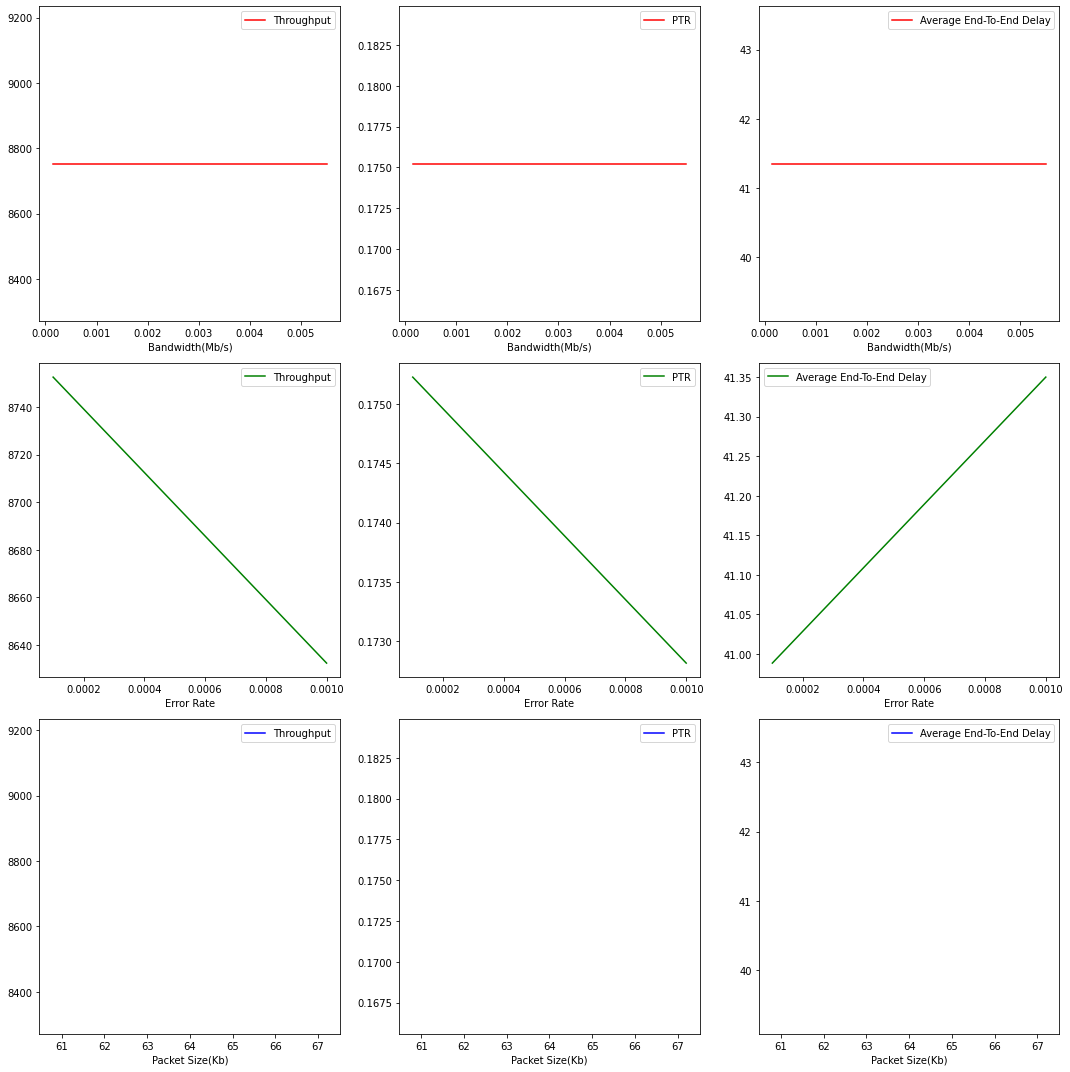

In [15]:
X = ['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)']
Y = ['Throughput', 'PTR', 'Average End-To-End Delay']

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))
i,j = 0, 0
colors = ["r", "g", "b"]

for x in X:
    for y in Y:
        unindexed_results.groupby(by=x).max().plot(y=y, ax=axes[i, j], color=colors[i])
        j += 1
    j = 0
    i += 1

plt.tight_layout()
plt.show()

## Analysis of the plots

<h4>
    Based on the plots for bandwidth, the rates don't change.<br>
    This is because the rate of our packets and their size is small compared with the given bandwidths.<br>
    The error rate does have some effect on our calculated rates.<br>
    By increasing the error rate, throughput and PTR decrease. This is because the rate of packets that are successfully transfered is decreased.<br>
    Packet size has positive effect on the rates.<br>
    Obviously, increasing the size of our packets will decrease the number of dropped packets and eventually increase throughput which is the transfered bits to total time.<br>
    Note that increasing the packet size too much will result in the decrease of the rates. If the size is too large, an error will cause a large amount of bits to be lost and this will significantly decrease throughput.
</h4>

## References

[1] http://nsnam.sourceforge.net/wiki/index.php/NS-2_Trace_Formats<br>
[2] https://ns2simulator.com/ns2-trace-file-format/<br>
[3] https://www.sfu.ca/~ljilja/ENSC427/Spring13/Projects/team11/WiFi_project_report_final.pdf<br>
[4] https://github.com/dtaht/ns2/blob/master/tcl/edu/rts-cts/rts-cts-data-ack.tcl
